In [1]:
from astropy.time import Time, TimeDelta
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sunpy.io.special import read_genx
# Note this load in is a WIP during the refactor/rename
from sunkit_spex.sunxspex_fitting.fitter import Fitter
# Old way which might not work now.....
# from sunxspex.sunxspex_fitting.fitter import SunXspex

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 


In [2]:
plt.rcParams.update({'font.size': 18,'font.family':"sans-serif",\
                         'font.sans-serif':"Arial",'mathtext.default':"regular"})

In [3]:
# Some setup for sunxspex
time_profile_size = (9,6)
spec_single_plot_size = (6,8)
spec_plot_size = (16,10)
spec_font_size = 18
default_font_size = 10
xlims, ylims = [3,100], [5e-2,3e2]
tol = 1e-5

fdir="/Users/iain/github/rhessi_spectra/figs/"
_dir = "/Users/iain/github/rhessi_spectra/fits/"

In [4]:
fname="20061117_051230"
# use the summed over 3 detectors
# At the moment f_vth can't go >200 keV so can't use binning code 22, instead using 1
spec = Fitter(pha_file=_dir+fname+"_spec_sum_eb1.fits", 
                srm_file=_dir+fname+"_srm_sum_eb1.fits")

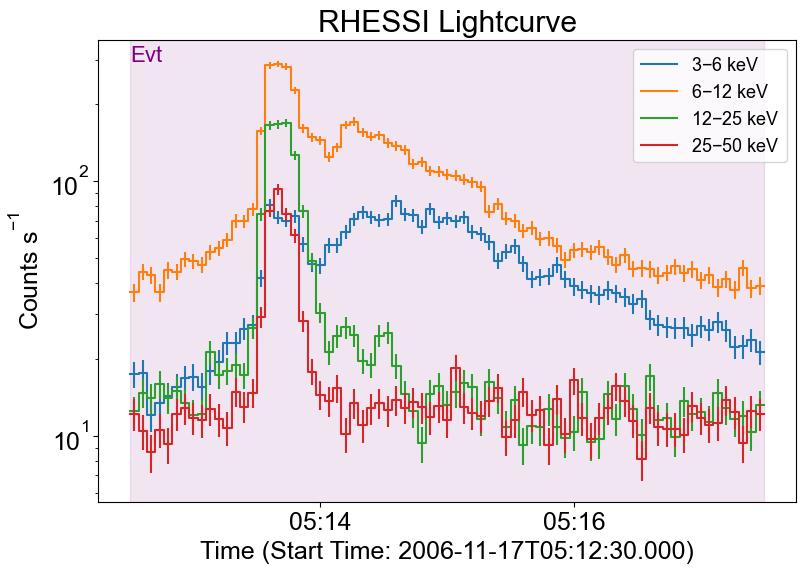

In [5]:
plt.rcParams['font.size'] = spec_font_size
plt.figure(figsize=time_profile_size)

# the line that actually plots
spec.data.loaded_spec_data['spectrum1'].lightcurve(energy_ranges=[[3,6], [6,12], [12,25],[25,50]])

plt.show()
plt.rcParams['font.size'] = default_font_size

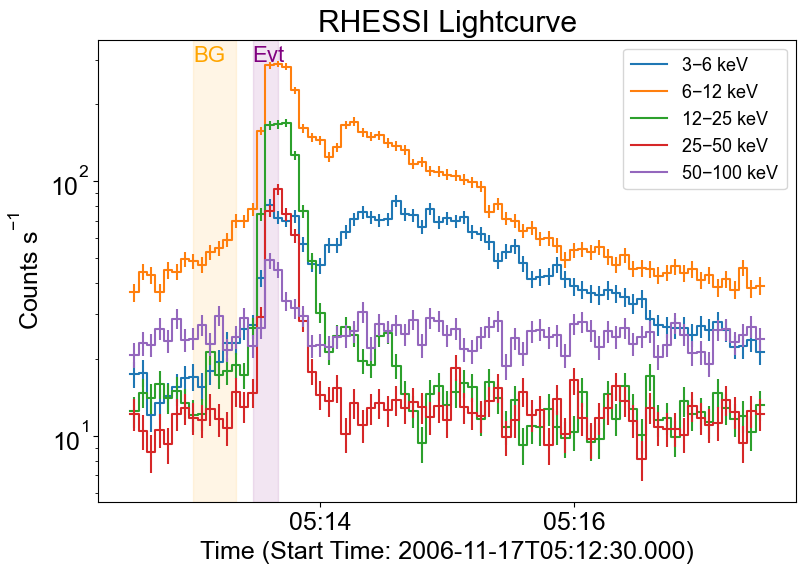

In [6]:
spec.data.loaded_spec_data['spectrum1'].start_background_time = "2006-11-17T05:13:00.000"
spec.data.loaded_spec_data['spectrum1'].end_background_time = "2006-11-17T05:13:20.000"

# event time
spec.data.loaded_spec_data['spectrum1'].start_event_time = "2006-11-17T05:13:28.000"
spec.data.loaded_spec_data['spectrum1'].end_event_time = "2006-11-17T05:13:40.000"

# plot again
plt.rcParams['font.size'] = spec_font_size
plt.figure(figsize=time_profile_size)
spec.data.loaded_spec_data['spectrum1'].lightcurve(energy_ranges=
                                                   [[3,6], [6,12], [12,25],[25,50],[50,100]])
plt.show()
plt.rcParams['font.size'] = default_font_size

In [7]:
spec.model = "f_vth+thick_fn"
spec.loglikelihood = "cstat"
# spec.loglikelihood = "poisson" # This shouldn't be used with RHESSI data....
spec.show_params

Param,Status,Value,Bounds,Error
,,,"(min, max)","(-, +)"
str22,str11,float64,object,object
T1_spectrum1,free,1.00e+00,"(0.0, None)","( 0.00e+00, 0.00e+00)"
EM1_spectrum1,free,1.00e+00,"(0.0, None)","( 0.00e+00, 0.00e+00)"
total_eflux1_spectrum1,free,1.00e+00,"(0.0, None)","( 0.00e+00, 0.00e+00)"
index1_spectrum1,free,1.00e+00,"(0.0, None)","( 0.00e+00, 0.00e+00)"
e_c1_spectrum1,free,1.00e+00,"(0.0, None)","( 0.00e+00, 0.00e+00)"
Fit Stat.,cstat ln(L),0.00e+00,--,--


In [8]:
# Just fit thermal part first and set the bounds

spec.energy_fitting_range = [4,12]
spec.params["T1_spectrum1"] = {"Value":23, "Bounds":(7, 30)}
spec.params["EM1_spectrum1"] = {"Value":1e-2, "Bounds":(1e-3, 1e2)}
spec.params["total_eflux1_spectrum1"] = {"Status":"fix", "Value":0.09, "Bounds":(1e-2, 1e2)}
spec.params["index1_spectrum1"] = {"Status":"fix", "Value":3.11, "Bounds":(2.5, 10)}
spec.params["e_c1_spectrum1"] = {"Status":"fix", "Value":8.41, "Bounds":(7, 30)}
spec_fit = spec.fit()

# Then non-thermal fit higher energy
spec.energy_fitting_range = [12,50]
spec.params["T1_spectrum1"] = "fix"
spec.params["EM1_spectrum1"] = "fix"
spec.params["total_eflux1_spectrum1"] = "free"
spec.params["index1_spectrum1"] = "free"
spec.params["e_c1_spectrum1"] = "free"
spec_fit = spec.fit()

# The do the full range
spec.energy_fitting_range = [4,50]
spec.params["T1_spectrum1"] = "free"
spec.params["EM1_spectrum1"] = "free"
spec.params["total_eflux1_spectrum1"] = "free"
spec.params["index1_spectrum1"] = "free"
spec.params["e_c1_spectrum1"] = "free"
spec_fit = spec.fit()


In [9]:
print(spec.params)

                       Status      Value          Bounds   
T1_spectrum1             free  17.370096         (7, 30)  \
EM1_spectrum1            free   0.051522  (0.001, 100.0)   
total_eflux1_spectrum1   free   0.015045   (0.01, 100.0)   
index1_spectrum1         free   3.729877       (2.5, 10)   
e_c1_spectrum1           free  29.871976         (7, 30)   

                                                               Error  
T1_spectrum1                  (2.480145151333073, 2.480145151333073)  
EM1_spectrum1             (0.02596233388851428, 0.02596233388851428)  
total_eflux1_spectrum1  (0.004009619051792069, 0.004009619051792069)  
index1_spectrum1            (0.3609388005022395, 0.3609388005022395)  
e_c1_spectrum1                (6.456281779109241, 6.456281779109241)  


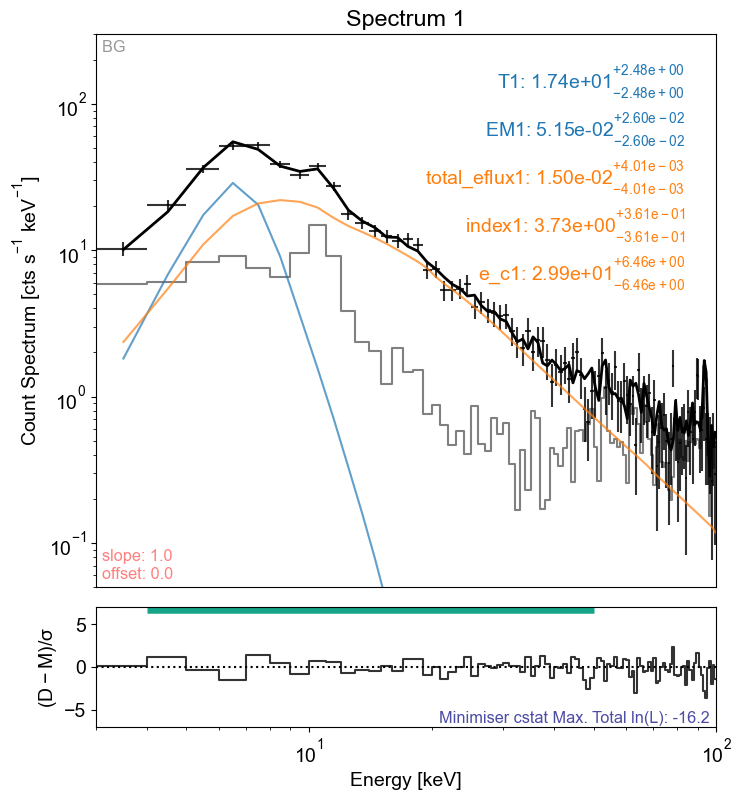

In [10]:
# Remember that sunxspex plots the background and data, 
# whereas ospex did background and data-background
# So total model black line is thermal+non-thermal+background

plt.rcParams['font.size'] = 14
plt.figure(figsize=[8,9])
axes, res_axes = spec.plot()
for a in axes:
    a.set_xlim(xlims)
    a.set_ylim(ylims)
    a.set_xscale("log")
plt.show()


In [11]:
mcmc_result = spec.run_mcmc(steps_per_walker=1000,walker_spread='mag_order')

100%|██████████| 1000/1000 [01:36<00:00, 10.39it/s]


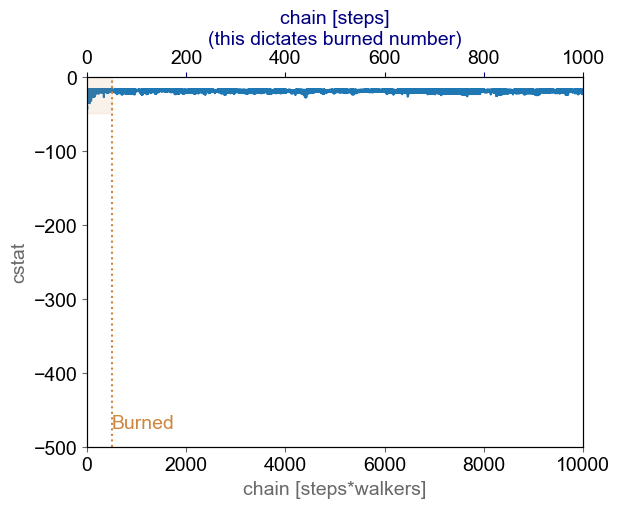

In [12]:
spec.burn_mcmc = 50
plt.figure()
spec.plot_log_prob_chain()
plt.ylim([-500,0])
plt.show()

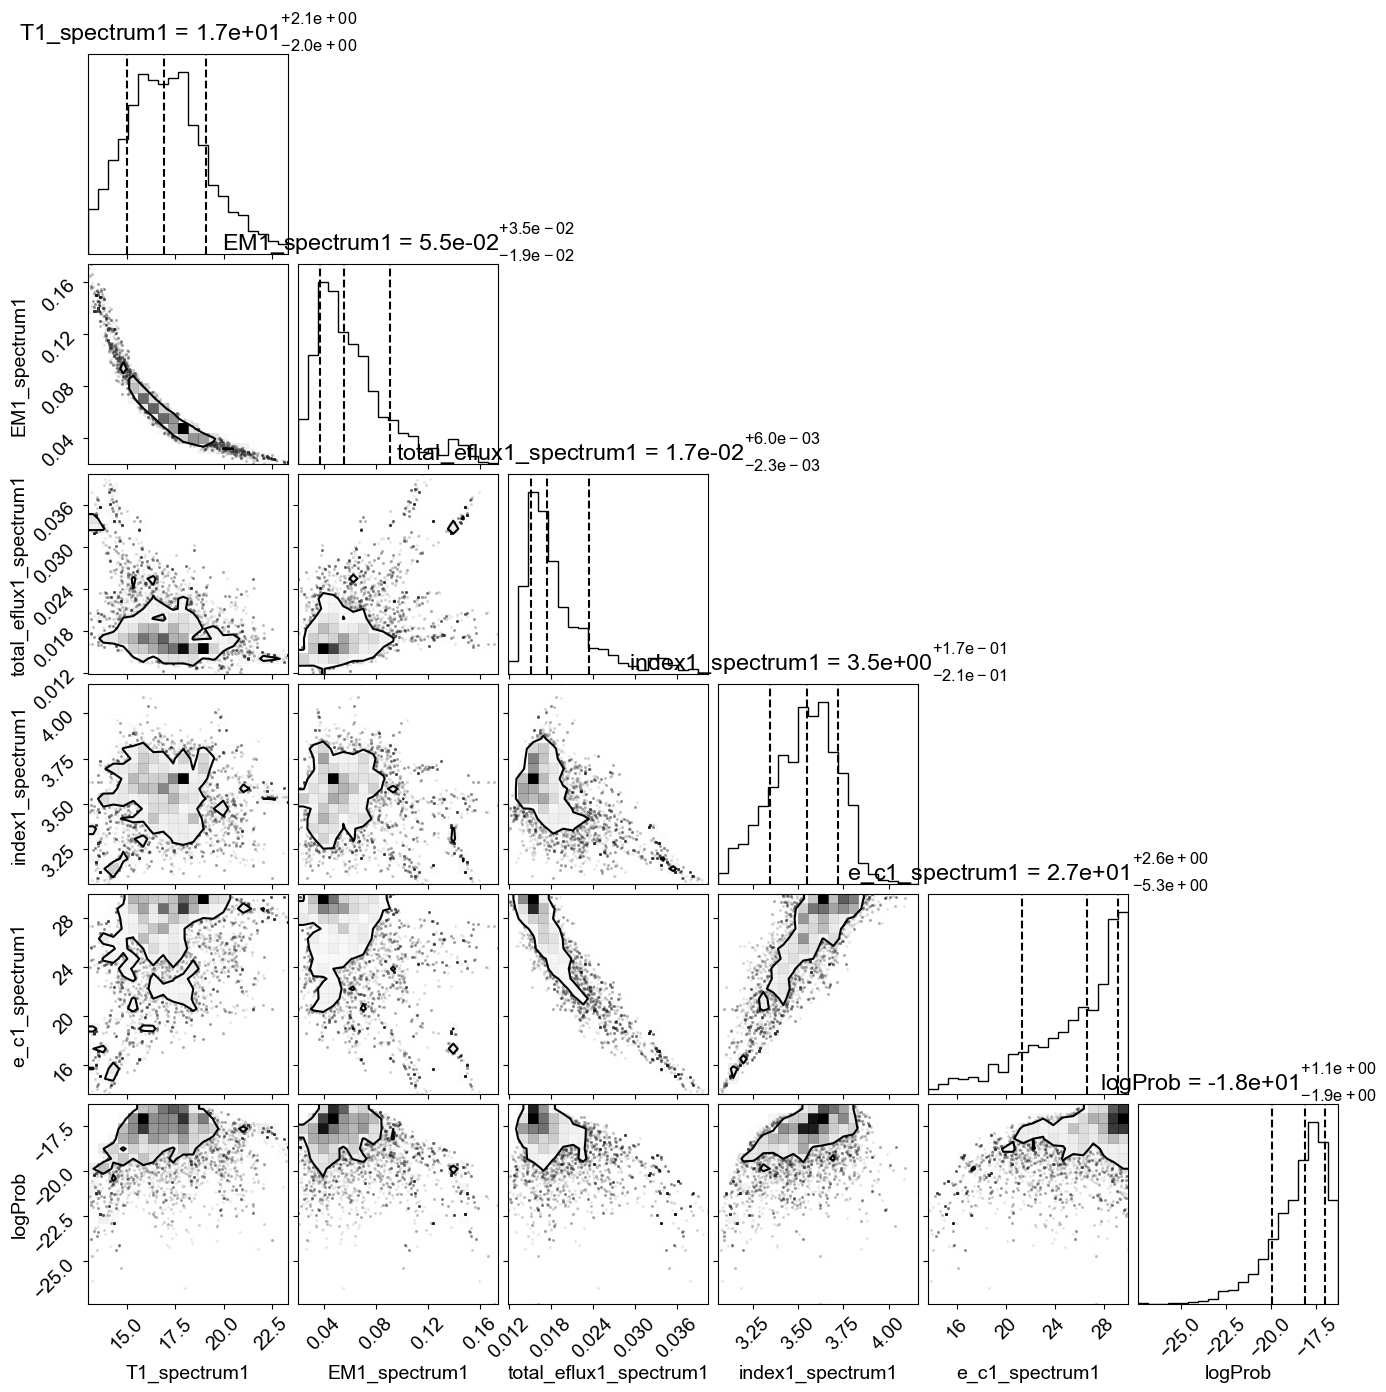

In [13]:
corner_plot = spec.corner_mcmc()

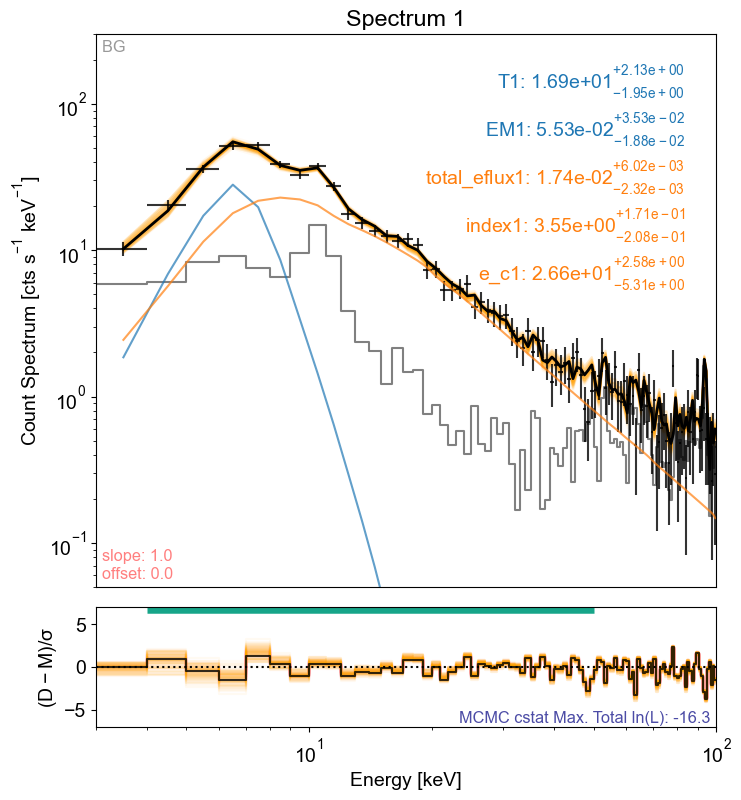

In [14]:
plt.rcParams['font.size'] = 14
plt.figure(figsize=[8,9])
axes, res_axes = spec.plot()
for a in axes:
    a.set_xlim(xlims)
    a.set_ylim(ylims)
    a.set_xscale("log")
plt.show()
